# Toronto Neighbourhood New Restaurant Opening Recommendation System
### by
## ***Nouman Aftab***

In [1]:
import pandas as pd

In [1]:
#!conda install --yes -c conda-forge geopy

In [5]:
from geopy.geocoders import Nominatim
import requests
import folium
import re
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

## Getting Merged Data into dataframe

In [6]:
MD_df = pd.read_csv('CS_MERGED_DATA.csv')

In [7]:
MD_df.head(2)

,Borough,Neighbourhood,Latitude,Longitude,Avg Crime,Employment,Population,Density,Avg Income,Transit_Commuting_Percent,Second_Language_Percent,Recreation Places Count
0,North York,Parkwoods,43.753259,-79.329656,12.27,2995.34,26533,5349,34811,14.0,0.0,2
1,North York,Victoria Village,43.725882,-79.315572,33.62,7520.42,17047,3612,29657,15.6,0.0,4


## Making function to points plot on map to be callable

In [8]:
def Plot_Points(df, circleColor, circleBorderColor, map):
    for lat, lng, borough, neighborhood in zip(df['Latitude'], 
    df['Longitude'], df['Borough'], df['Neighbourhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=circleColor,
        fill=True,
        fill_color=circleBorderColor,
        fill_opacity=0.7,
        parse_html=False).add_to(map)

## Accessing Toronto City Latitude & Longitude using geolocator

In [9]:
address = 'Toronto City, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

The geograpical coordinate of Toronto, Canada are 43.7189883, -79.44157.


## Displaying all the Neighbourhoods with available data

In [10]:
Plot_Points(MD_df, 'blue', '#0000ff', map_Toronto)
map_Toronto

## Data type conversion for processing

In [11]:
MD_df.drop('Transit_Commuting_Percent', axis=1, inplace=True)
MD_df[MD_df.columns[3:12]]=MD_df[MD_df.columns[3:12]].astype(float)


In [12]:
#MD_df.head(2)
MD_df.dtypes

Borough                     object
Neighbourhood               object
Latitude                   float64
Longitude                  float64
Avg Crime                  float64
Employment                 float64
Population                 float64
Density                    float64
Avg Income                 float64
Second_Language_Percent    float64
Recreation Places Count    float64
dtype: object

# KMeans Clustering

## Weights setting for low crime in a neighbourhood and high for the rest columns

#### Required Avg Crime in Neighbourhood = low, better the safety more people for outing
#### Required Employment in Neighbourhood = high, so people could more likely to go to restaurant
#### Required Population in Neighbourhood = high, more population more crowd in restaurant
#### Required Density in Neighbourhood = high, more density more crowd in restaurant
#### Required Avg Income in Neighbourhood = high, to spend more
#### Required Transit Commuting Percent in Neighbourhood = high, more activity more probability of dining
#### Required Second Language Percent in Neighbourhood = high, more italian people good chance of selling
#### Required Recreation Places in Neighbourhood = high, more padestrian more selling

In [15]:
scaler = MinMaxScaler(feature_range=(0,10))
Weights = [1,10,10,10,10,10,10]

## Plotting a graph of kmeans clustering response inertia for selection of optimum 'k' value

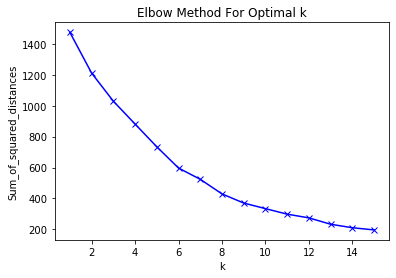

In [16]:
SSD=[]

k = 15

for k in range(1,k+1):
    temp = MD_df.drop('Borough', axis=1).copy()
    temp = temp.drop('Neighbourhood', axis=1)
    temp = temp.drop('Latitude', axis=1)
    temp = temp.drop('Longitude', axis=1)
    temp = scaler.fit_transform(temp)

    # run k-means clustering
    kmeans = KMeans(init = "k-means++", n_clusters=k, n_init=12, random_state=0).fit(temp)

    SSD.append(kmeans.inertia_)

plt.plot(range(1,k+1), SSD, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
MD_df.head(2)

,Borough,Neighbourhood,Latitude,Longitude,Avg Crime,Employment,Population,Density,Avg Income,Second_Language_Percent,Recreation Places Count
0,North York,Parkwoods,43.753259,-79.329656,12.27,2995.34,26533.0,5349.0,34811.0,0.0,2.0
1,North York,Victoria Village,43.725882,-79.315572,33.62,7520.42,17047.0,3612.0,29657.0,0.0,4.0


## From the graph it is observed that the elbow occurs at k=6, though it is not very clear

In [18]:
# set number of clusters
k = 6

Rest_df = MD_df.drop('Borough', axis=1).copy()
Rest_df = Rest_df.drop('Neighbourhood', axis=1)
Rest_df = Rest_df.drop('Latitude', axis=1)
Rest_df = Rest_df.drop('Longitude', axis=1)
Rest_df = scaler.fit_transform(Rest_df)


# run k-means clustering
kmeans = KMeans(init = "k-means++", n_clusters=k, n_init=12, random_state=0).fit(Rest_df)

# add clustering labels
MD_df.insert(2, 'Cluster Labels', kmeans.labels_)

## Plotting neighbourhood clusters

In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

kclusters = k
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MD_df['Latitude'], MD_df['Longitude'],MD_df['Neighbourhood'], MD_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
    
map_clusters

['#8000ff', '#1996f3', '#4df3ce', '#b2f396', '#ff964f', '#ff0000']


In [20]:
MD_df.head(3)

,Borough,Neighbourhood,Cluster Labels,Latitude,Longitude,Avg Crime,Employment,Population,Density,Avg Income,Second_Language_Percent,Recreation Places Count
0,North York,Parkwoods,0,43.753259,-79.329656,12.27,2995.34,26533.0,5349.0,34811.0,0.0,2.0
1,North York,Victoria Village,2,43.725882,-79.315572,33.62,7520.42,17047.0,3612.0,29657.0,0.0,4.0
2,Downtown Toronto,Regent Park,0,43.654260,-79.360636,23.68,2064.24,10387.0,16230.0,19521.0,0.0,0.0


## Creating a new data frame for clusters and its respective distance

In [22]:
Restaurant_Location_Clusters = pd.DataFrame(columns = ['Cluster', 'Distance'])
Restaurant_Location_Clusters

,Cluster,Distance


## Selection of cluster that matches with requirements

In [23]:
for iter in range(k):
    tmp = MD_df[MD_df['Cluster Labels'] == iter].reset_index(drop=True)
    tmp[tmp.columns[5:12]] = scaler.fit_transform(tmp[tmp.columns[5:12]])
    ClusterMean = tmp[tmp.columns[5:12]].mean()
    Restaurant_Location_Clusters.loc[iter] = [str(iter) , distance.euclidean(ClusterMean, Weights)]

#print(Restaurant_Location_Clusters)
Restaurant_Location_Clusters = Restaurant_Location_Clusters.sort_values('Distance', ascending=True).reset_index(drop=True)
#print(Restaurant_Location_Clusters.dtypes)
Restaurant_Location_Clusters['Cluster'] = Restaurant_Location_Clusters['Cluster'].astype(int)
#print(Restaurant_Location_Clusters['Cluster'].loc[0])
RecommendedRestaurantLocations = MD_df[MD_df['Cluster Labels'] == Restaurant_Location_Clusters['Cluster'].loc[0]]
print('Selected Custer = {}'.format(Restaurant_Location_Clusters['Cluster'].loc[0]))

Selected Custer = 4


In [24]:
RecommendedRestaurantLocations

,Borough,Neighbourhood,Cluster Labels,Latitude,Longitude,Avg Crime,Employment,Population,Density,Avg Income,Second_Language_Percent,Recreation Places Count
17,North York,Downsview,4,43.754328,-79.442259,24.72,21540.35,36613.0,2270.0,26751.0,11.7,12.0
29,North York,Humber Summit,4,43.756303,-79.565963,11.15,19188.55,12766.0,1618.0,26117.0,15.1,1.0


In [25]:
TorontoMap = folium.Map(location=[latitude, longitude], zoom_start=10)
Plot_Points(RecommendedRestaurantLocations, 'green', '#00ff00', TorontoMap)
TorontoMap

In [26]:
RecommendedRestaurantLocations

,Borough,Neighbourhood,Cluster Labels,Latitude,Longitude,Avg Crime,Employment,Population,Density,Avg Income,Second_Language_Percent,Recreation Places Count
17,North York,Downsview,4,43.754328,-79.442259,24.72,21540.35,36613.0,2270.0,26751.0,11.7,12.0
29,North York,Humber Summit,4,43.756303,-79.565963,11.15,19188.55,12766.0,1618.0,26117.0,15.1,1.0
